In [11]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn
import tidytcells

seaborn.set_theme()
seaborn.set_style("darkgrid")
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [2]:
raw_dir = Path(
    "/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/raw/tanno"
)
preprocessed_dir = Path(
    "/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno"
)

In [3]:
example = pd.read_csv(raw_dir / "data" / "A1 memory.txt", sep="\t")

In [4]:
example.sort_values(by="Clustered", ascending=False).head()

,Clustered,Collapsed,ClusterID,CDRH3_AA,CDRL3_AA,CDRH3_NT,CDRL3_NT,VH,DH,JH,VL,JL
0,8899,5544,1,CASSLQGARETQYF,CALLSTGGGNKLTF,TGTGCCAGCAGCTTACAGGGGGCGCGGGAGACCCAGTACTTC,TGTGCTCTCCTTTCCACGGGAGGAGGAAACAAACTCACCTTT,TRBV11-2,TRBD1,TRBJ2-5,TRAV9-2,TRAJ10
1,1945,1077,2,CSWKREIVEQFF,CAVSDRNTNAGKSTF,TGCAGTTGGAAGCGGGAGATAGTTGAGCAGTTCTTC,TGTGCTGTGAGTGATAGGAACACCAATGCAGGCAAATCAACCTTT,TRBV20-1,TRBD2,TRBJ2-1,TRAV8-4,TRAJ27
2,1215,867,3,CASSSQGANTEAFF,CIVRKRNQFYF,TGTGCCAGCAGCTCCCAAGGAGCGAACACTGAAGCTTTCTTT,TGCATCGTCAGAAAACGTAACCAGTTCTATTTT,TRBV9,NaN,TRBJ1-1,TRAV26-1,TRAJ49
3,1185,866,4,CASSFQGQGGQPQHF,CAVRPRDTGGFKTIF,TGTGCCAGCAGTTTCCAGGGACAGGGCGGTCAGCCCCAGCATTTT,TGTGCTGTGAGGCCTCGGGATACTGGAGGCTTCAAAACTATCTTT,TRBV12-3,TRBD1,TRBJ1-5,TRAV21,TRAJ9
4,1002,785,5,CSAPLAGVSYNEQFF,CIVRSYNYGQNFVF,TGCAGTGCGCCACTAGCGGGCGTCTCCTACAATGAGCAGTTCTTC,TGCATCGTCAGATCTTATAACTATGGTCAGAATTTTGTCTTT,TRBV20-1,TRBD2,TRBJ2-1,TRAV26-1,TRAJ26


In [5]:
dfs = []

for f in (raw_dir / "data").iterdir():
    df = pd.read_csv(f, sep="\t")

    # Filter for potential mispairings
    df = df.sort_values(by="Clustered", ascending=False)
    df = df.drop_duplicates("CDRH3_NT", keep="first")
    df = df.drop_duplicates("CDRL3_NT", keep="first")

    df = df[["VL", "CDRL3_AA", "JL", "VH", "CDRH3_AA", "JH"]]
    df = df.drop_duplicates()
    df.columns = ["TRAV", "CDR3A", "TRAJ", "TRBV", "CDR3B", "TRBJ"]
    df["Epitope"] = pd.NA
    df["MHCA"] = pd.NA
    df["MHCB"] = pd.NA
    df["duplicate_count"] = pd.NA

    dfs.append(df)

combined = pd.concat(dfs, axis="index")
combined = combined.drop_duplicates()
combined = combined.sort_values(by=combined.columns.tolist(), ignore_index=True)

In [6]:
combined["TRAV"] = combined["TRAV"].map(
    lambda x: tidytcells.tcr.standardise(x, enforce_functional=True)
)
combined["TRAJ"] = combined["TRAJ"].map(
    lambda x: tidytcells.tcr.standardise(x, enforce_functional=True)
)
combined["TRBV"] = combined["TRBV"].map(
    lambda x: tidytcells.tcr.standardise(x, enforce_functional=True)
)
combined["TRBJ"] = combined["TRBJ"].map(
    lambda x: tidytcells.tcr.standardise(x, enforce_functional=True)
)

/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.8/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV11" for species homosapiens. Attempted fix "TRAV11" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.8/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV15" for species homosapiens. Attempted fix "TRAV15" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.8/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV32" for species homosapiens. Attempted fix "TRAV32" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.8/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to stan

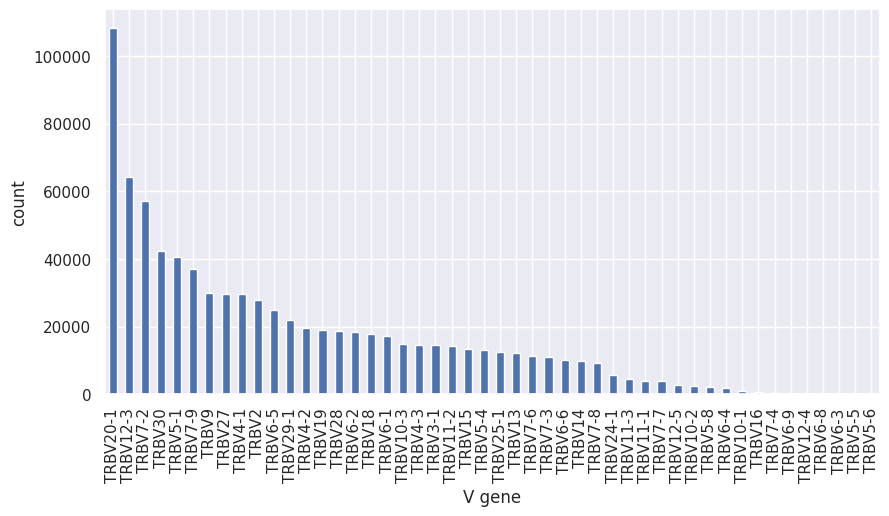

In [7]:
ax = combined["TRBV"].value_counts().plot.bar()
ax.set_ylabel("count")
ax.set_xlabel("V gene")
ax.get_figure().set_size_inches(10, 5)

In [13]:
with open("trbv_frequencies.json", "w") as f:
    json.dump(combined["TRBV"].value_counts(normalize=True).to_dict(), f, indent=4)

In [8]:
combined.to_csv(preprocessed_dir / "combined.csv", index=False)

In [9]:
test_frac = 0.1
test_rows = int(test_frac * len(combined))

shuffled = combined.sample(frac=1, random_state=420)

test = shuffled.iloc[:test_rows]
train = shuffled.iloc[test_rows:]

In [10]:
travs = tidytcells.tcr.query(precision="gene", functionality="F", contains="TRAV")
trajs = tidytcells.tcr.query(precision="gene", functionality="F", contains="TRAJ")
trbvs = tidytcells.tcr.query(precision="gene", functionality="F", contains="TRBV")
trbjs = tidytcells.tcr.query(precision="gene", functionality="F", contains="TRBJ")

In [13]:
for dataset in (train, test):
    assert dataset["TRAV"].nunique() == len(travs)
    assert not (set(travs) - set(dataset["TRAV"]))
    assert dataset["TRAJ"].nunique() == len(trajs)
    assert not (set(trajs) - set(dataset["TRAJ"]))
    assert dataset["TRBV"].nunique() == len(trbvs)
    assert not (set(trbvs) - set(dataset["TRBV"]))
    assert dataset["TRBJ"].nunique() == len(trbjs)
    assert not (set(trbjs) - set(dataset["TRBJ"]))
    print(dataset["TRBV"].value_counts())

TRBV20-1    97492
TRBV12-3    57756
TRBV7-2     51351
TRBV30      38143
TRBV5-1     36462
TRBV7-9     33495
TRBV9       27154
TRBV27      26669
TRBV4-1     26585
TRBV2       24967
TRBV6-5     22318
TRBV29-1    19902
TRBV4-2     17603
TRBV19      17273
TRBV28      16807
TRBV6-2     16661
TRBV18      15992
TRBV6-1     15623
TRBV10-3    13384
TRBV4-3     13211
TRBV3-1     13018
TRBV11-2    12839
TRBV15      12186
TRBV5-4     11898
TRBV25-1    11284
TRBV13      11080
TRBV7-6     10278
TRBV7-3      9948
TRBV6-6      9174
TRBV14       8857
TRBV7-8      8373
TRBV24-1     5257
TRBV11-3     4172
TRBV11-1     3630
TRBV7-7      3599
TRBV12-5     2601
TRBV10-2     2230
TRBV5-8      1975
TRBV6-4      1806
TRBV10-1      950
TRBV16        506
TRBV7-4       389
TRBV12-4      150
TRBV6-9       144
TRBV6-8       141
TRBV6-3        99
TRBV5-6        55
TRBV5-5        52
Name: TRBV, dtype: int64
TRBV20-1    10904
TRBV12-3     6441
TRBV7-2      5704
TRBV30       4296
TRBV5-1      4077
TRBV7-9      3639
TRB

In [14]:
train.to_csv(preprocessed_dir / "train.csv", index=False)
test.to_csv(preprocessed_dir / "test.csv", index=False)

In [17]:
test.sample(n=5, random_state=420).to_csv(
    preprocessed_dir / "exemplars.csv", index=False
)